In [1]:
%load_ext autoreload
%autoreload 2
!pip install matplotlib torch


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:9]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper']

In [5]:
len(words)

32033

In [68]:
chars = list(set("".join(words)))
stoi = {v:k+1 for k,v in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}
print(stoi)
print(itos)
print(len(chars))

{'g': 1, 'i': 2, 'z': 3, 'x': 4, 't': 5, 'e': 6, 'f': 7, 'm': 8, 'a': 9, 'k': 10, 'u': 11, 'r': 12, 'h': 13, 'l': 14, 'q': 15, 'd': 16, 's': 17, 'w': 18, 'o': 19, 'p': 20, 'v': 21, 'j': 22, 'c': 23, 'y': 24, 'n': 25, 'b': 26, '.': 0}
{1: 'g', 2: 'i', 3: 'z', 4: 'x', 5: 't', 6: 'e', 7: 'f', 8: 'm', 9: 'a', 10: 'k', 11: 'u', 12: 'r', 13: 'h', 14: 'l', 15: 'q', 16: 'd', 17: 's', 18: 'w', 19: 'o', 20: 'p', 21: 'v', 22: 'j', 23: 'c', 24: 'y', 25: 'n', 26: 'b', 0: '.'}
26


In [334]:
# build the dataset

i = 0
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

    i += 1
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [335]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [336]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  6],
         [ 0,  6,  8],
         ...,
         [ 3,  3, 24],
         [ 3, 24,  3],
         [24,  3,  4]]),
 tensor([6, 8, 8,  ..., 3, 4, 0]))

In [337]:
C = torch.randn((27,2))
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# same as

C[5]
C.shape

torch.Size([27, 2])

In [338]:
print('X[0]', X[0])
print('C[0]', C[0])
emb_small = C[X[0]]
print('emb.shape', emb_small.shape)
print('emb', emb_small)


X[0] tensor([0, 0, 0])
C[0] tensor([ 0.2696, -0.7716])
emb.shape torch.Size([3, 2])
emb tensor([[ 0.2696, -0.7716],
        [ 0.2696, -0.7716],
        [ 0.2696, -0.7716]])


NOTE THIS ASSUMES  words = words[:5]

So the input X is (32, 3), aka 32 rows and 3 columns (3 represents the tri-gram)
C is our (27,2) dimensional embedding array, 27 is the number of characters in our vocabulary, 2 dim embedding for each character

C[X] is asking for embeddings for (32, 3) -> (32, 3, 2)

In [339]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [340]:
# input size is 6: 3 x 2 dim embeddings
# output layer: optional hyper parameter
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [341]:
# or we could have used emb = emb.view(32, 6) emb = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)
emb = emb.view(emb.shape[0], 6)

In [342]:
h = torch.tanh(emb @ W1 + b1)

In [343]:
h.shape

torch.Size([228146, 100])

In [344]:
h

tensor([[ 0.8933, -0.9944,  0.9598,  ...,  0.9561,  0.1733,  0.2231],
        [-0.9656, -0.9608,  0.9729,  ..., -0.2273, -0.5750,  0.9926],
        [ 0.9998,  0.2936, -0.8736,  ..., -0.7252,  0.3228,  0.3095],
        ...,
        [-0.4972,  0.9988, -0.9999,  ..., -0.9698, -0.0800,  0.9314],
        [-0.9989,  0.9995, -0.9970,  ..., -0.9859, -0.9576,  0.8962],
        [-0.9936,  0.9924, -0.9690,  ..., -0.9698, -0.2309,  0.8017]])

In [345]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [346]:
logits = h @ W2 + b2

In [347]:
logits.shape

torch.Size([228146, 27])

In [348]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [349]:
prob[torch.arange(32),Y]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
-prob[torch.arange(32),Y].log().mean()

tensor(21.5603)

In [351]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [355]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

In [ ]:
loss = F.cross_entropy(logits, Y)
loss

tensor(2.0259, grad_fn=<NllLossBackward0>)

In [353]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, steps=1000)
lrs = 10**lre

In [ ]:
lri = []
lossi =[]
for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    emb = C[X[ix]]
    emb = emb.view(-1, 6)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad


    lri.append(lre[i].item())
    lossi.append(loss.item())



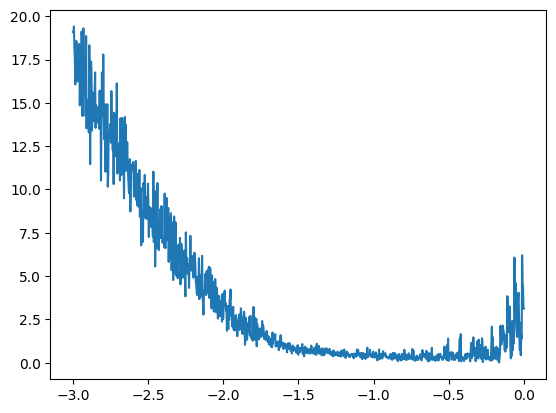

In [ ]:
plt.plot(lri, lossi);

In [ ]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.0259125232696533


In [354]:

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    emb = C[X[ix]]
    emb = emb.view(-1, 6)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    
    for p in parameters:
        p.data += -.1 * p.grad


loss.item()


2.373643636703491

In [356]:
# training, test and valdiation splits

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [382]:
for i in range(30000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]
    emb = emb.view(-1, 6)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    
    for p in parameters:
        p.data += -.01 * p.grad


loss.item()

2.4528610706329346

In [383]:
# evaluate on training set

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())


# evaluate on dev set

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2472121715545654
2.254636287689209


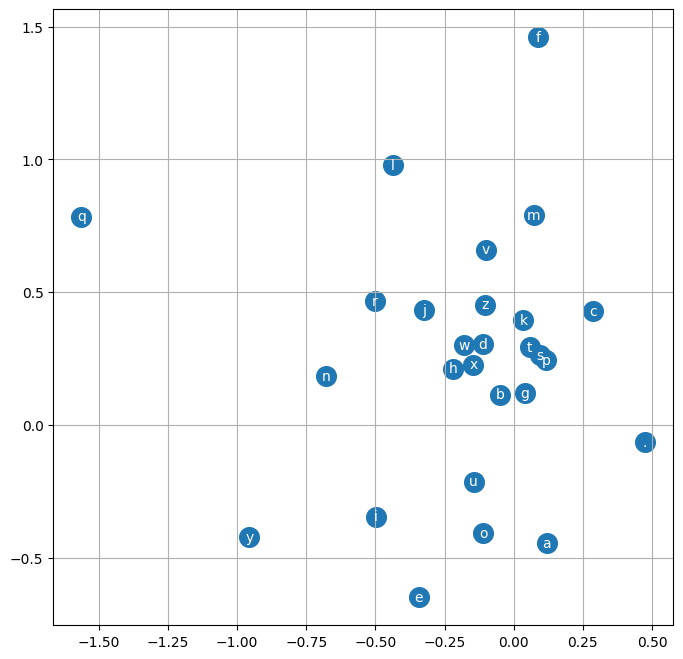

In [384]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [385]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

zikhameshina.
jamiahriyara.
namiren.
lakeliannesh.
anaz.
afsta.
luwela.
kzahami.
jormendi.
rhy.
jayleian.
allyn.
caraylis.
colter.
akeweya.
esstadavori.
tent.
aad.
fareemane.
sradsoni.
